## Notebook Overview

This notebook presents the complete end-to-end pipeline for a **Brain Tumor Detection** model, encompassing data acquisition, exploratory analysis, preprocessing, model development, and fine-tuning. The resulting model performs **binary classification**, where:

- **0** → No tumor detected  
- **1** → Tumor detected  

The notebook has been developed and tested in **Google Colab** and runs successfully without requiring any additional package installations. For reference, the third cell lists the most recently tested versions of the required libraries.

---

## Workflow Summary

1. **Imports**  
   All necessary libraries and dependencies are imported to support data handling, model training, evaluation, and optimization.

2. **Data Acquisition**  
   The dataset is downloaded directly from Kaggle:  
   https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

3. **Exploratory Data Analysis (EDA)**  
   The images are analyzed to understand their structure, modality (CT and MRI), and relevant contextual characteristics critical to tumor detection.

4. **Data Transformations**  
   Appropriate image transformations are carefully selected to preserve all diagnostically significant features. Given the clinical sensitivity of the task and the spatial dispersion of critical information within each image, transformations are designed to avoid any loss of relevant detail.

5. **Cross-Validation Strategy**  
   The training pipeline is implemented to support **on-the-fly cross-validation**. This design choice is necessary because only a subset of the dataset can be augmented, and care is taken to prevent class imbalance in the binary prediction task.

6. **Model Architecture and Optimization**  
   A convolutional neural network is constructed with sufficient depth to capture the complexity of the data while avoiding overfitting.  
   - The baseline model achieves approximately **95% accuracy**.  
   - Further optimization is performed using **Optuna**, resulting in improved performance across key metrics through systematic hyperparameter tuning and criterion selection.  
   - Design decisions, particularly those related to preprocessing, validation, and model capacity (Steps 4–6), are thoroughly documented in the subsequent cells.

7. **Final Model Export**  
   After achieving satisfactory **precision** and **recall**, the trained model is saved as `final_model.pth`.  
   The file can be found in the project root directory:

   ```text
   ./final_model.pth

In [ ]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.3 MB/s eta 0:00:00


In [ ]:
import kagglehub
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from PIL import Image
from torchvision.transforms import v2
import torch
from torch import nn
import torch.nn.functional as F
from typing import List
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import random
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import copy
import optuna
import joblib

In [ ]:
target_dir = "/brain_scans/1"
download_dir = "/brain_scans"

def safe_transfer(src, dst):
    try:
        shutil.move(src, dst)
    except OSError:
        if os.path.isdir(src):
            dst_path = os.path.join(dst, os.path.basename(src))
            shutil.copytree(src, dst_path, dirs_exist_ok=True)
        else:
            shutil.copy2(src, dst)


if not os.path.exists(target_dir) or not os.listdir(target_dir):
    print("Downloading and preparing dataset...")

    dataset_path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

    os.makedirs(download_dir, exist_ok=True)
    safe_transfer(dataset_path, download_dir)

    source_dir = os.path.join(download_dir, os.path.basename(dataset_path))

    for root, dirs, files in os.walk(source_dir):
        rel_path = os.path.relpath(root, source_dir)
        dest_root = os.path.join(target_dir, rel_path)
        os.makedirs(dest_root, exist_ok=True)
        for file_name in files:
            src_file = os.path.join(root, file_name)
            dest_file = os.path.join(dest_root, file_name)
            if os.path.exists(dest_file):
                print(f"Skipping existing file: {dest_file}")
                continue
            shutil.copy2(src_file, dest_file)

    print(f"Dataset prepared at: {target_dir}")
else:
    print(f"Dataset already exists in {target_dir}, skipping download.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


In [ ]:
directories = [
    "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
    "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor",
    "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy",
    "/brain_scans/1/Dataset/Brain Tumor MRI images/Tumor"
]

non_jpg_png_counts = []

for dir in directories:
    files = os.listdir(dir)
    non_jpg_png_files = [f for f in files if not (f.endswith('.jpg') or f.endswith('.png'))]
    non_jpg_png_counts.append(len(non_jpg_png_files))

print("Number of non-.jpg and non-.png files in each directory:", non_jpg_png_counts)


Number of non-.jpg and non-.png files in each directory: [0, 0, 3, 16]


In [ ]:
directories = [
    "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
    "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor",
    "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy",
    "/brain_scans/1/Dataset/Brain Tumor MRI images/Tumor"
]

non_jpg_png_files = {}

for dir in directories:
    files = os.listdir(dir)
    non_jpg_png = [f for f in files if not (f.endswith('.jpg') or f.endswith('.png'))]
    if non_jpg_png:
        non_jpg_png_files[dir] = non_jpg_png

print("Files with extensions other than .jpg and .png:")
for dir, files in non_jpg_png_files.items():
    print(f"\nDirectory: {dir}")
    for file in files:
        print(f"  - {file}")


Files with extensions other than .jpg and .png:

Directory: /brain_scans/1/Dataset/Brain Tumor MRI images/Healthy
  - mri_healthy (3).jpeg
  - mri_healthy (1).jpeg
  - mri_healthy (2).jpeg

Directory: /brain_scans/1/Dataset/Brain Tumor MRI images/Tumor
  - tumor (12).jpeg
  - tumor (4).jpeg
  - tumor (11).jpeg
  - tumor (13).jpeg
  - tumor (3).jpeg
  - tumor (5).jpeg
  - tumor (8).jpeg
  - tumor (9).jpeg
  - tumor (7).jpeg
  - tumor (10).jpeg
  - tumor (2).jpeg
  - tumor (16).jpeg
  - tumor (1).jpeg
  - tumor (14).jpeg
  - tumor (6).jpeg
  - tumor (15).jpeg


In [ ]:
directories = ["/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Tumor"
               ]

image_files = [[] for _ in range(len(directories))]

for i, dir in enumerate(directories):
    image_files[i] = [f for f in os.listdir(dir) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]

In [ ]:
def see_least(image_files) -> int: #desc shall be added
    return np.min([np.shape(row)[0] for row in image_files])

In [ ]:
for directory in directories:
    print(f"Number of images in {directory}: {len(os.listdir(directory))}")

Number of images in /brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy: 2300
Number of images in /brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor: 2318
Number of images in /brain_scans/1/Dataset/Brain Tumor MRI images/Healthy: 2000
Number of images in /brain_scans/1/Dataset/Brain Tumor MRI images/Tumor: 3000


In [ ]:
see_least(image_files)

np.int64(2000)

In [ ]:
image_files[1][1]

'ct_tumor (348).jpg'

The conclusions to be derived from this, shall be as follow, the network should be of mediocre depth, the data should be augmented, and in the second step I presume that making double or triple Conv2d, might yield proper results due to the intricateness combined with modelling of the data. More so the triple layer, with higher breadth.

In [ ]:
path = "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (1196).jpg"
img = Image.open(path)
width, height = img.size
height

640

In [ ]:
group_sizes = [np.shape(group)[0] for group in image_files] #They should be of equal sizes i.e. for now the model will(in terms of logical inference) be biased towards saying tumor
group_sizes

[2300, 2318, 2000, 3000]

In [ ]:
widths, heights = [[0 for x in range(group_sizes[y])] for y in range(4)], [[0 for x in range(group_sizes[y])] for y in range(4)]
for i, group in enumerate(image_files):
    for j, file in enumerate(group):
        path = directories[i] + f"/{file}"
        img = Image.open(path)
        width, height = img.size
        widths[i][j] = width
        heights[i][j] = height




In [ ]:
np.min([np.min(row) for row in widths])

np.int64(100)

In [ ]:
np.max([np.max(row) for row in widths]) # This easy test proofs the disproportions, I shall do smth about this.

np.int64(1375)

In [ ]:
def show_images():
    tumor_scans_in_divisions = [
        "Healthy, CT scan images",
        "Sick, CT scan images",
        "Healthy MRI images",
        "Sick MRI images"
    ]
    print("Brain scans pre-classified by tumor occurence \n\n\n")

    for i, group in enumerate(image_files):

        images = [[None for _ in range(2)] for _ in range(2)]

        rand_img_indices = []

        for j in range(2):
            for k in range(2):
                rand_img_index = np.random.randint(low=0, high=len(group))
                if not rand_img_indices:
                    rand_img_indices.append(np.random.randint(low=0, high=len(group)))
                else:
                    if rand_img_index in rand_img_indices:
                        while rand_img_index in rand_img_indices:
                            rand_img_indices.append(np.random.randint(low=0, high=len(group)))
                    else:
                        rand_img_indices.append(np.random.randint(low=0, high=len(group)))
                imgpath = os.path.join(directories[i], group[rand_img_index])
                print(Image.open(imgpath).size[0])
                img = mpimg.imread(imgpath)
                images[j][k] = img

        random_img_indices_2d = [
            [rand_img_indices[x] for x in range(y * 2, (y + 1) * 2)]
            for y in range(2)
        ]

        fig, axes = plt.subplots(figsize=(9, 6), nrows=2, ncols=2)

        for k, row in enumerate(axes):
            for l, element in enumerate(axes[k]):
                element.imshow(images[k][l], cmap="gray")
                element.set_title(
                    f"Scan number {random_img_indices_2d[k][l]}., file size = "
                    f"{Image.open(imgpath).size[0]} x {Image.open(imgpath).size[1]}"
                )
                element.axis('off')
        plt.suptitle(f"{tumor_scans_in_divisions[i]}")
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        print("\n\n")


Brain scans pre-classified by tumor occurence 



640
512
512
640


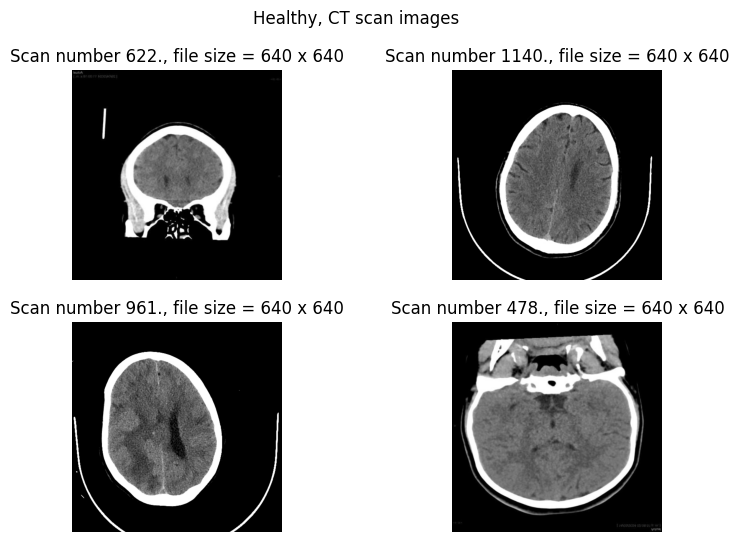




640
640
640
640


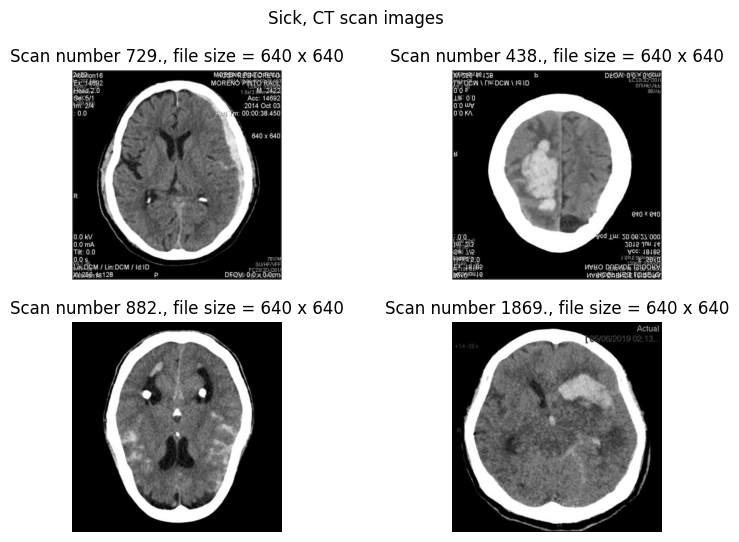




1024
640
225
256


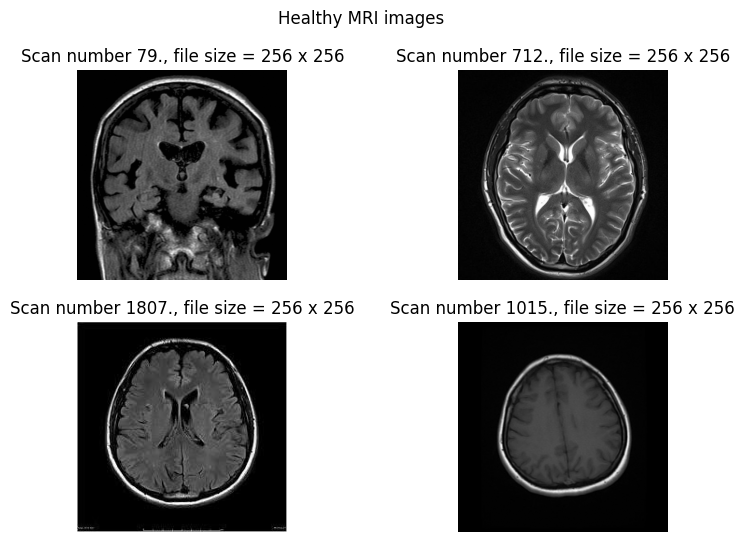




512
256
315
512


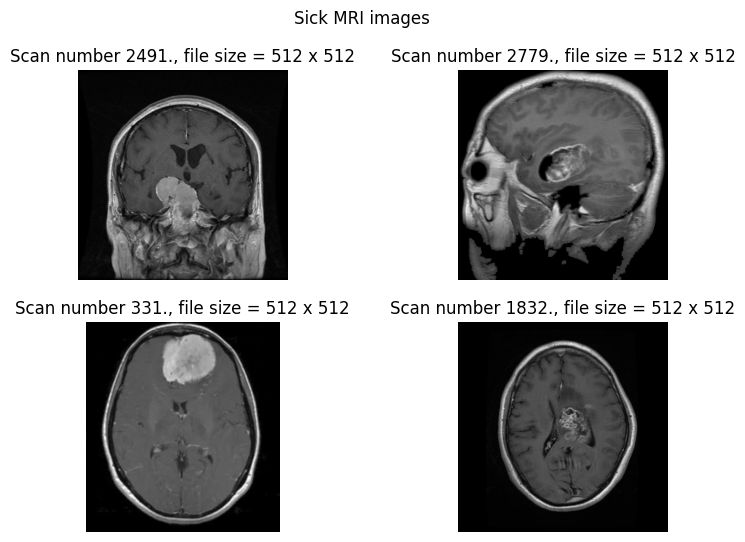

In [ ]:
show_images()

In [ ]:
"""
WIthin checking the current structure of the images with the dataset, I shall split the data into categories min-256px, 256-513, 513-max, within the
visualization, and the focus shall be redirected to the tumor positive images, due to their more specific (intricate) relationships between pixels (I assume)
"""

'\nWIthin checking the current structure of the images with the dataset, I shall split the data into categories min-256px, 256-513, 513-max, within the\nvisualization, and the focus shall be redirected to the tumor positive images, due to their more specific (intricate) relationships between pixels (I assume)\n'

In [ ]:
tumor_scans_in_divisions = ["Healthy, CT scan images",
                             "Sick, CT scan images",
                             "Healthy MRI images",
                             "Sick MRI images"]

def images_by_their_size(min_size: int, max_size: int, resizer=False, scaler=224) -> None:
    print("Brain scans pre-classified by tumor occurrence\n\n\n")

    if resizer:
        resizer = v2.Resize((scaler, scaler))

    for i, group in enumerate(image_files):
        images = [[None for _ in range(2)] for _ in range(2)]
        rand_img_indices = set()

        limit = 100
        for j in range(2):
            for k in range(2):
                attempts = 0
                while attempts < limit:
                    rand_img_index = np.random.randint(low=0, high=len(group))
                    if rand_img_index not in rand_img_indices:
                        imgpath = os.path.join(directories[i], group[rand_img_index])
                        img_size = Image.open(imgpath).size
                        if min_size <= img_size[0] < max_size and min_size <= img_size[1] < max_size:
                            rand_img_indices.add(rand_img_index)
                            img = mpimg.imread(imgpath)
                            if resizer:
                                img_uint8 = (img * 255).astype(np.uint8) if img.dtype == np.float32 else img.astype(np.uint8)
                                img = np.array(resizer(Image.fromarray(img_uint8)))

                            images[j][k] = img
                            break
                    attempts += 1
                else:
                    print(f"Warning: Unable to find a valid image for position ({j}, {k})")
                    images[j][k] = None

        if len(rand_img_indices) < 4:
            print("Insufficient images were found to fill all slots.")
            continue

        fig, axes = plt.subplots(figsize=(9, 6), nrows=2, ncols=2)
        for k, row in enumerate(axes):
            for l, ax in enumerate(row):
                if images[k][l] is not None:
                    ax.imshow(images[k][l], cmap="gray")
                    ax.set_title(f"Scan number {list(rand_img_indices)[k * 2 + l]}, size: {scaler if resizer else img_size}")
                ax.axis('off')
        plt.suptitle(f"{tumor_scans_in_divisions[i]}")
        plt.show()
        print("\n\n")


Brain scans pre-classified by tumor occurrence





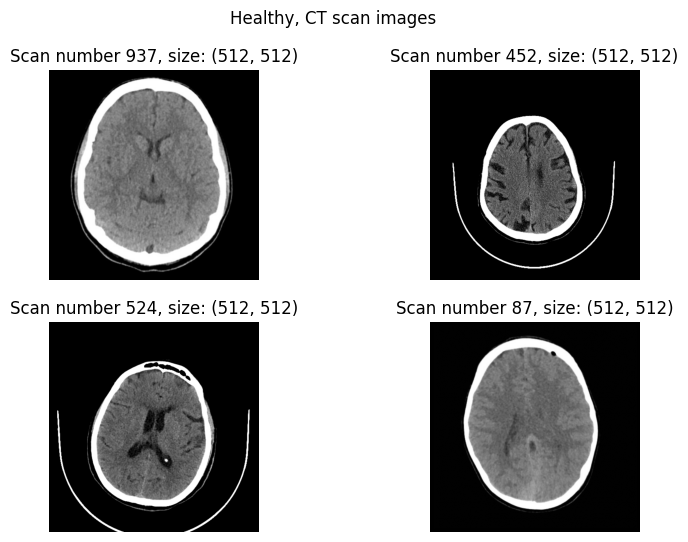

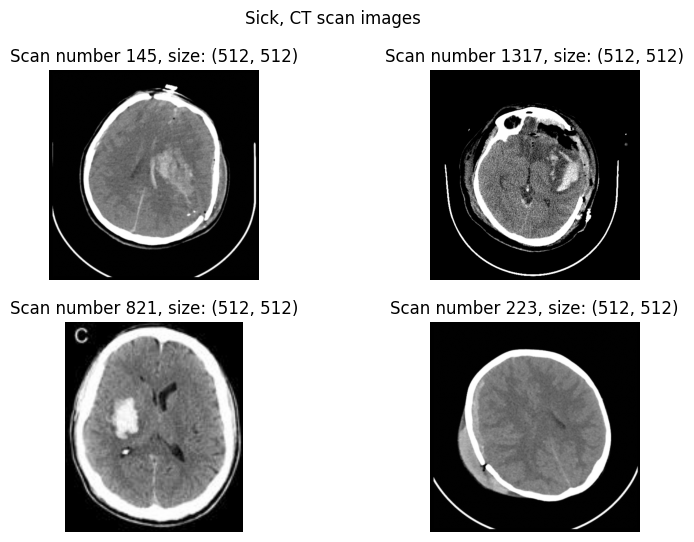

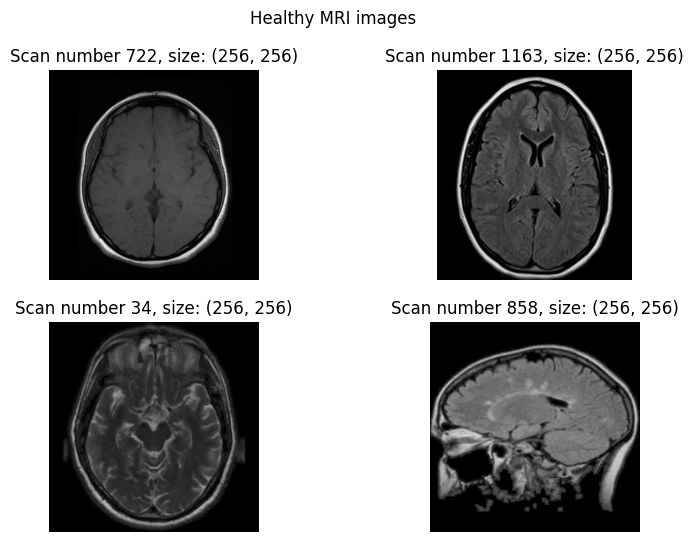

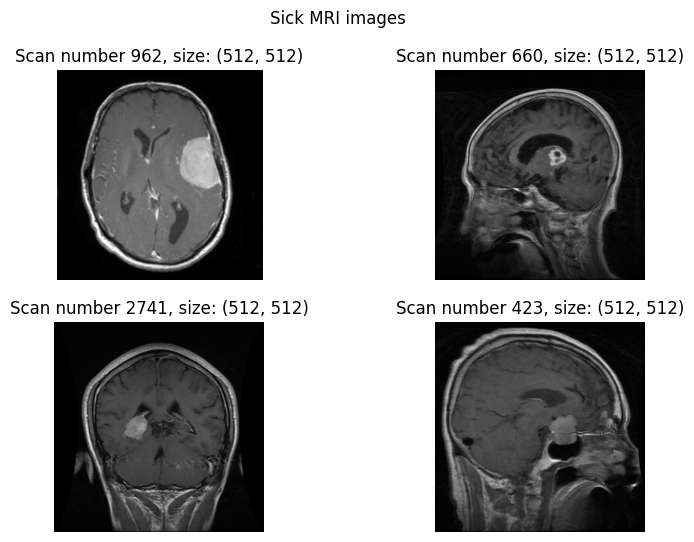

In [ ]:
images_by_their_size(256, 513)

Brain scans pre-classified by tumor occurrence





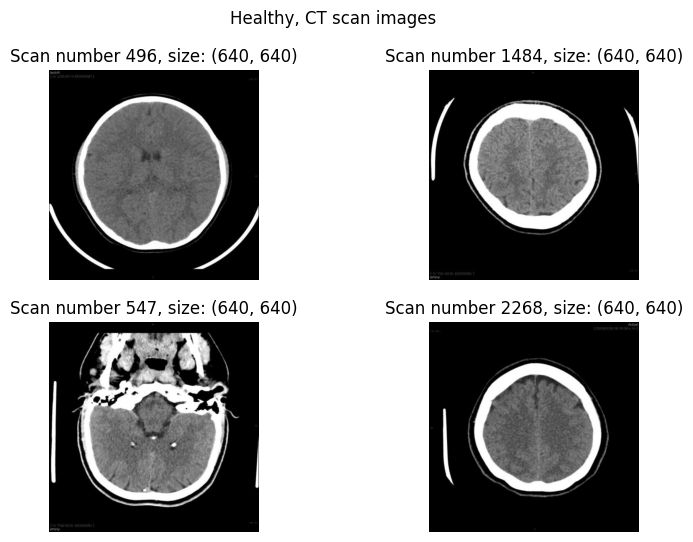

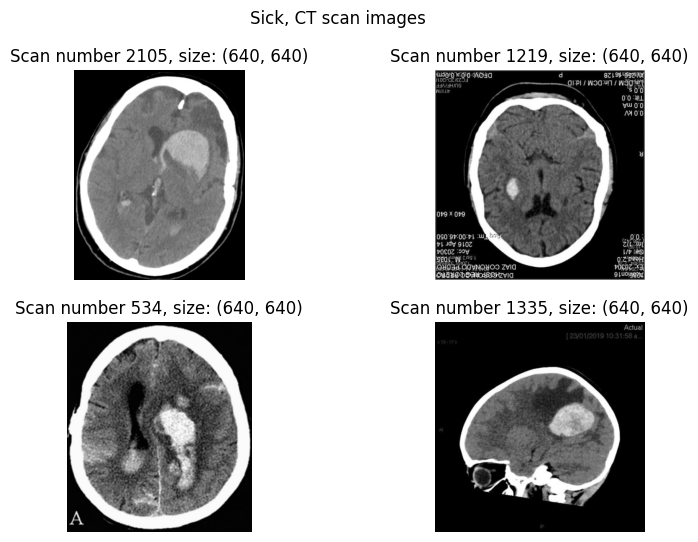

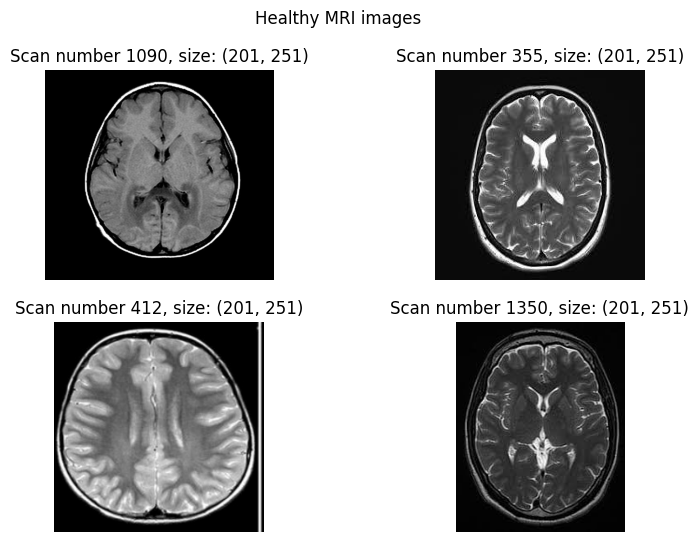

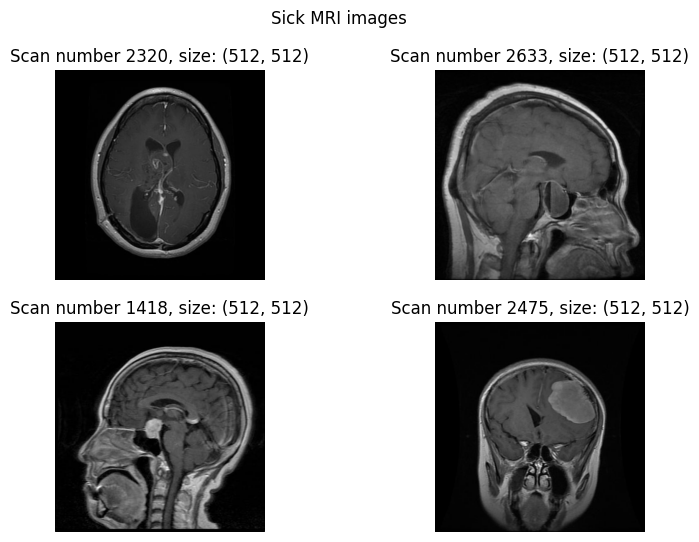

In [ ]:
images_by_their_size(2, 2000)

Brain scans pre-classified by tumor occurrence





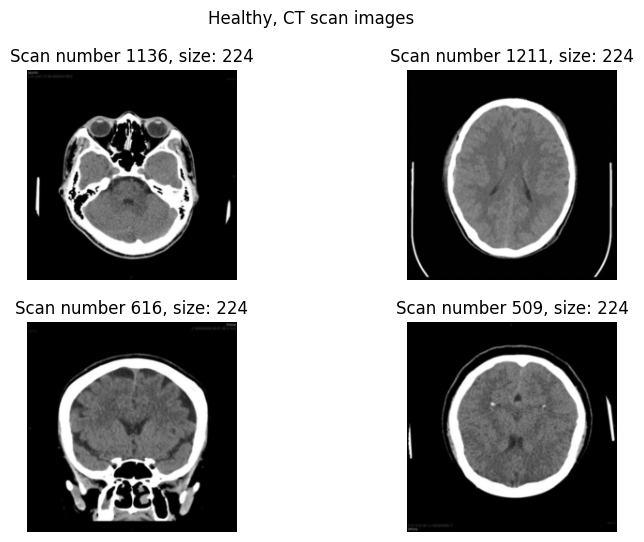

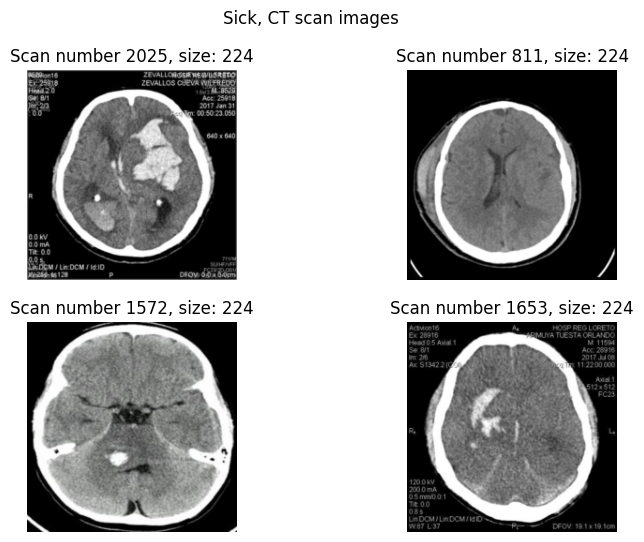

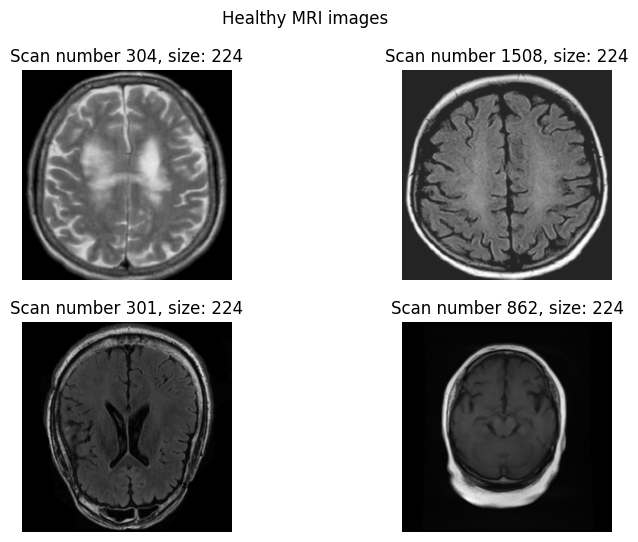

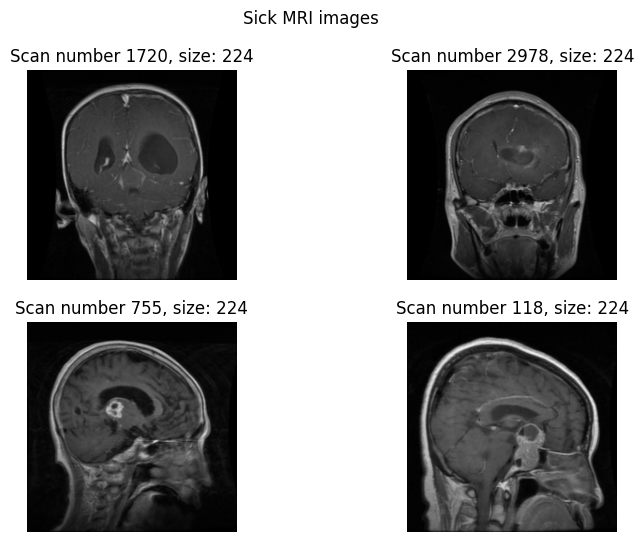

In [ ]:
images_by_their_size(2, 2000, resizer = True, scaler = 224)

In [ ]:
data_transformation = v2.Compose([
    #v2.RandomRotation(degrees=4), # It is too much, it distorts this image too much
    v2.RandomVerticalFlip(0.8),
    v2.RandomHorizontalFlip(0.8),
    # v2.RandomResizedCrop(x, x), This also shall not be a good idea, for my previous inference yielded, that I should not go below 196^2
    # v2.RandomResizedCrop(size=(170, 170)), I shouldnt use it, for brain tumor in some pictures might be invisible, cause of crop
    #v2.ColorJitter(brightness=0.2, contrast=0.2), # i though that to a little whit it might be good, but it fails...
    v2.Pad(padding = 20), # roughly 10% of the basic image shall be a good level
    #Random invert should make it too hard for model, to see intricacies... (I will not even test it, generally for things like crop i wont even do them)
    #v2.RandomAdjustSharpness(sharpness_factor=2, p=0.65), # Bad idea, images are too distorted...
    v2.Resize((196, 196)), # General resizing will happen on the fly, this is upscaling, to make it harder for model to overfit
    v2.Grayscale(num_output_channels=1),
    v2.ToTensor()
])
#This is the final version of this v2.Compose object
#In the model I will use CV, thus I shall augment the data on the fly

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
tumor_scans_in_divisions = ["Healthy, CT scan images",
                             "Sick, CT scan images",
                             "Healthy MRI images",
                             "Sick MRI images"]

def images_from_numpy_preprocessed(augmenter = v2.Compose([v2.ToTensor()])) -> None:
    print("Brain scans pre-classified by tumor occurrence, with given preprocessing\n\n\n")

    for i, group in enumerate(image_files):
        images = [[None for _ in range(2)] for _ in range(2)]
        rand_img_indices = set()

        limit = 100
        for j in range(2):
            rand_img_index = np.random.randint(low=0, high=len(group))
            while rand_img_index in rand_img_indices:
                rand_img_index = np.random.randint(low=0, high=len(group))
            imgpath = os.path.join(directories[i], group[rand_img_index])
            img = Image.open(imgpath)
            img = img.convert('L')
            img = torch.from_numpy(np.array(img)).float()
            img = img.unsqueeze(0)
            images[j][0] = img
            images[j][1] = augmenter(img)

        fig, axes = plt.subplots(figsize=(9, 6), nrows=2, ncols=2)
        for k, row in enumerate(axes):
            for l, ax in enumerate(row):
                ax.imshow(images[k][l].squeeze().numpy(), cmap="gray")
                if l == 0:
                    ax.set_title(f"Original brain scan")
                else:
                    ax.set_title(f"Augmented brain scan")
                ax.axis('off')
        plt.suptitle(f"{tumor_scans_in_divisions[i]}")
        plt.show()
        print("\n\n")


Brain scans pre-classified by tumor occurrence, with given preprocessing





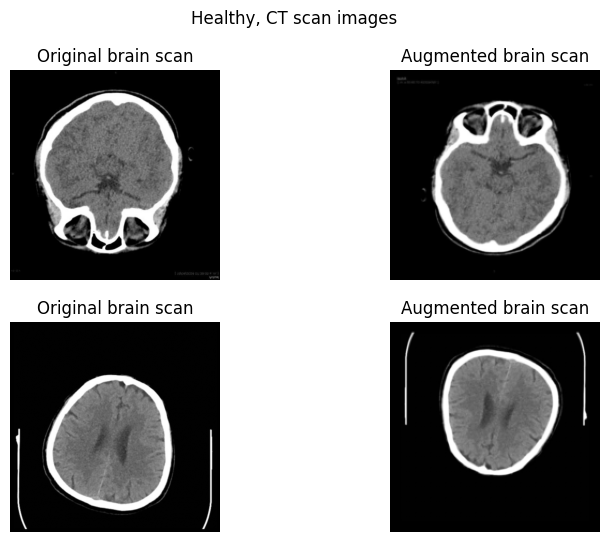

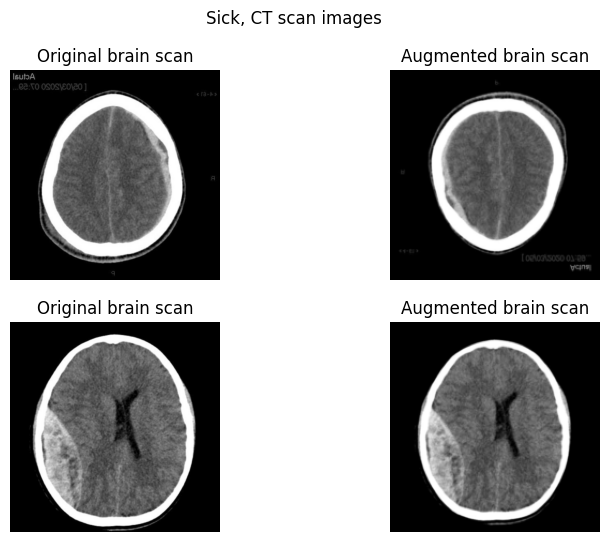

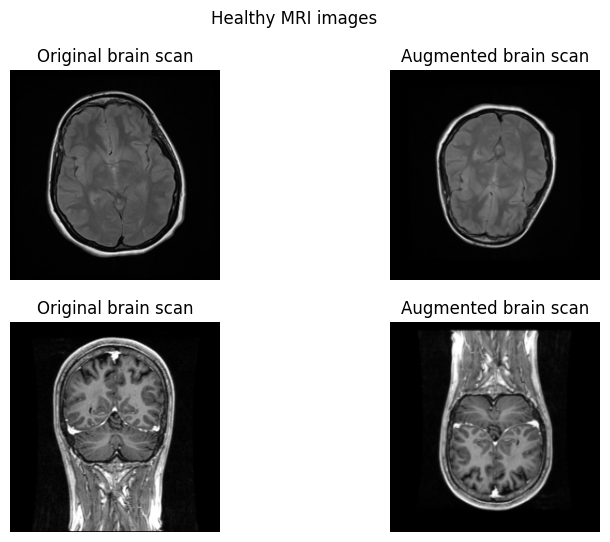

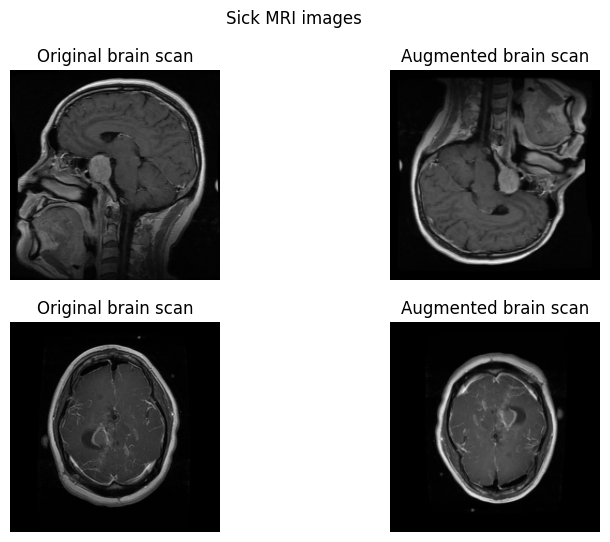

In [ ]:
images_from_numpy_preprocessed(data_transformation)

In [ ]:
"""
# This can be easily commented, but do the same with the two cells beneath, lest not want an error.
directories = ["/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy",
               "/brain_scans/1/Dataset/Brain Tumor MRI images/Tumor"
               ]

images_resized = [[] for _ in range(len(directories))]

resizer = v2.Resize((196, 196))

for i, group in enumerate(image_files):
    for j, path in enumerate(group):
        img_path = os.path.join(directories[i], path)
        try:
            img = Image.open(img_path)
            img = img.convert('L')
            img = resizer(img)
            img.save(img_path)
        except Exception as e:
            print(f"The error: {e} occured in image: {img_path}")
        finally:
            img = torch.from_numpy(np.array(img)).float()
            img = img.unsqueeze(0)
            images_resized[i].append(resizer(img))

"""
"""

images_resized[0] -> CT scan Healthy
images_resized[1] -> CT scan Sick
images_resized[2] -> MRI scan Healthy
images_resized[3] -> MRI scan Sick

"""

'\n\nimages_resized[0] -> CT scan Healthy\nimages_resized[1] -> CT scan Sick\nimages_resized[2] -> MRI scan Healthy\nimages_resized[3] -> MRI scan Sick\n\n'

In [ ]:
"""
for i, group in enumerate(images_resized):
    print(len(group))
"""
# I cannot make it biased towards Sick that much, even though that recall is much more important here, for first model I shall
# use the same sizes of the MRI and CT relatively to themselves i.e. n/k = j/l

'\nfor i, group in enumerate(images_resized):\n    print(len(group))\n'

In [ ]:
"""
healthy = 0
sick = 0
for i, group in enumerate(images_resized):
    if i % 2 == 0: healthy += len(images_resized[i])
    else: sick += len(images_resized[i])
print(healthy, sick)
"""

'\nhealthy = 0\nsick = 0\nfor i, group in enumerate(images_resized):\n    if i % 2 == 0: healthy += len(images_resized[i])\n    else: sick += len(images_resized[i])\nprint(healthy, sick)\n'

POST MODEL CREATION NOTES

I have decided to reduce both, the validation and test sets, via augmenting the trainset, but not that it ONLY changes it's percentage values, not the real hard numbers. I had to do this due to the possible lack of proper data

In [ ]:
"""
# Will images be properly resized?
# print(images_resized[0][0].shape)
check = images_resized[0][0].shape
for i, group in enumerate(images_resized):
    for j, image in enumerate(group):
        if image.shape != check:
            print(f"Image with index {i}, {j} doesnt follow resized order")
            break
    else:
        continue
    break
"""

'\n# Will images be properly resized?\n# print(images_resized[0][0].shape)\ncheck = images_resized[0][0].shape\nfor i, group in enumerate(images_resized):\n    for j, image in enumerate(group):\n      if image.shape != check:\n        print(f"Image with index {i}, {j} doesnt follow resized order")\n        break\n    else:\n      continue\n    break\n'

In [ ]:
class BrainScanDataset(Dataset):
    def __init__(self, images_labeled, transform=None):
        self.images_labeled = list(zip(*images_labeled))
        self.transform = transform

    def __len__(self):
        return len(self.images_labeled)

    def __getitem__(self, idx):
        img_path, label = self.images_labeled[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)

        return img, label


In [ ]:
def balance_dataset(images, labels):
    counts = Counter(labels)

    majority_class = max(counts, key=counts.get)
    minority_class = min(counts, key=counts.get)

    maj_images, maj_labels = [], []
    min_images, min_labels = [], []

    for img, lbl in zip(images, labels):
        if lbl == majority_class:
            maj_images.append(img)
            maj_labels.append(1)
        else:
            min_images.append(img)
            min_labels.append(0)

    n_remove = len(maj_images) - len(min_images)

    maj_data = list(zip(maj_images, maj_labels))
    random.shuffle(maj_data)
    removed = maj_data[:n_remove]
    kept = maj_data[n_remove:]

    if removed:
        temp_images, temp_labels = zip(*removed)
        temp_images, temp_labels = list(temp_images), list(temp_labels)
    else:
        temp_images, temp_labels = [], []

    if kept:
        kept_images, kept_labels = zip(*kept)
        kept_images, kept_labels = list(kept_images), list(kept_labels)
    else:
        kept_images, kept_labels = [], []

    balanced_images = kept_images + min_images
    balanced_labels = kept_labels + min_labels

    return [balanced_images, balanced_labels, temp_images, temp_labels, n_remove]


In [ ]:
healthy_dirs = [
    "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Healthy",
    "/brain_scans/1/Dataset/Brain Tumor MRI images/Healthy"
]
sick_dirs = [
    "/brain_scans/1/Dataset/Brain Tumor CT scan Images/Tumor",
    "/brain_scans/1/Dataset/Brain Tumor MRI images/Tumor"
]

In [ ]:
data_transformation = v2.Compose([
    v2.RandomVerticalFlip(0.8),
    v2.RandomHorizontalFlip(0.8),
    v2.Pad(padding = 20),
    v2.Grayscale(num_output_channels=1),
    v2.Resize((196, 196)),
    v2.ToTensor()
])
base_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((196, 196)),
    v2.ToTensor()
])

In [ ]:
all_images = []
for i, dir in enumerate(directories):
    for j, file in enumerate(os.listdir(dir)):
        all_images.append((os.path.join(dir, file), i % 2))

paths, labels = zip(*all_images)

paths, labels = list(paths), list(labels)

images, labels, temp_images, temp_labels, to_remove_count = balance_dataset(paths, labels)
images, X_test, labels, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)  # Roughly 960 this amount neccessary, due to the fact, that I will test also best_model, from ranked accuracies
test_dataset = BrainScanDataset((X_test, y_test), transform=base_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
len(all_images)

9618

In [ ]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

n_loaders = 8
loaders = [(None, None) for _ in range(n_loaders)]

images_np = np.array(images)
labels_np = np.array(labels)

skf = StratifiedKFold(n_splits=n_loaders, shuffle=True, random_state=42) #5 splits, would give too much for validation set, 8 is good

for i, (train_index, val_index) in enumerate(skf.split(images_np, labels_np)):

    X_train = images_np[train_index]
    y_train = labels_np[train_index]
    X_val   = images_np[val_index]
    y_val   = labels_np[val_index]

    X_train = np.concatenate((X_train, temp_images), axis=0)
    y_train = np.concatenate((y_train, temp_labels), axis=0)

    healthy_idxs = np.where(y_train == 0)[0]
    sick_idxs    = np.where(y_train == 1)[0]

    n_healthy_aug = 1418
    n_sick_aug    = int(round((1418/2)*1.1))

    sel_h = np.random.choice(healthy_idxs, size=n_healthy_aug, replace=False)
    sel_s = np.random.choice(sick_idxs,    size=n_sick_aug,    replace=False)

    aug_h_images = X_train[sel_h]
    aug_h_labels = [0] * len(aug_h_images)

    aug_s_images = X_train[sel_s]
    aug_s_labels = [1] * len(aug_s_images)

    train_dataset = BrainScanDataset((X_train, y_train), transform=base_transform)
    aug_h_ds       = BrainScanDataset((aug_h_images, aug_h_labels), transform=data_transformation)
    aug_s_ds       = BrainScanDataset((aug_s_images, aug_s_labels), transform=data_transformation)
    extended_ds    = ConcatDataset([train_dataset, aug_h_ds, aug_s_ds])

    train_loader = DataLoader(extended_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(BrainScanDataset((X_val, y_val), transform=base_transform),
                              batch_size=32,
                              shuffle=False)

    loaders[i] = (train_loader, val_loader)


In [ ]:
def highest_ranked(ranks_hashed):
    if not ranks_hashed:
        return None

    max_value = max(ranks_hashed.values())
    candidates = [k for k, v in ranks_hashed.items() if v == max_value]

    return min(candidates)

In [ ]:
def ranked_most_common(val_accuracies):
    ranks_hashed = {}
    for row in val_accuracies:
        row_copy = row.copy()
        points = 3
        for _ in range(3):
            curr_best = max(row_copy)
            best_index = row_copy.index(curr_best)
            if best_index not in ranks_hashed:
                ranks_hashed[best_index] = points
            else:
                ranks_hashed[best_index] = ranks_hashed[best_index] + points
            points = points - 1
            row_copy[best_index] = -101.0
    return highest_ranked(ranks_hashed)


def calculate_final_best_accuracy(val_accuracies, most_frequent_best_index, n_loaders):
    val_accuracies_copy = [row.copy() for row in val_accuracies]
    final_best_accuracy = sum([val_accuracies_copy[x][most_frequent_best_index] for x in range(n_loaders)]) / float(n_loaders)
    return final_best_accuracy

In [ ]:
# Final_Model will serve for basic ideas within Optuna optimization.
# Images are all sized 196x196

class Final_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.AvgPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(55296, 256) # 24^2 * 96
        self.fc2 = nn.Linear(256, 1)
    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.flatten(x)
        x = self.fc2(F.relu(self.fc1(x)))
        return x

In [ ]:
num_epochs = 10
val_accuracies = [[None] * num_epochs for _ in range(n_loaders)]
best_model = None
best_f1_score = 0.0
fold = 0

for loader in loaders:
    train_loader, val_loader = loader
    print(f"Fold {fold+1}")

    model = Final_Model()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
    pos_weight = torch.tensor([1.005]).to(device)
    lossfun = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = lossfun(outputs, labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).long()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train Acc: {train_accuracy:.2f}%")

        model.eval()
        all_pred = []
        all_true = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                predicted = (torch.sigmoid(outputs) > 0.5).long()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_pred.extend(predicted.cpu().numpy())
                all_true.extend(labels.cpu().numpy())

        val_accuracy = 100 * val_correct / val_total
        print(f"Fold {fold+1}, epoch {epoch+1} Validation Accuracy: {val_accuracy:.2f}%")
        val_accuracies[fold][epoch] = val_accuracy

        cm = confusion_matrix(all_true, all_pred)
        tn, fp, fn, tp = cm.ravel()
        accuracy   = (tp + tn) / (tp + tn + fp + fn)
        precision  = tp / (tp + fp) if (tp + fp)>0 else 0.0
        recall     = tp / (tp + fn) if (tp + fn)>0 else 0.0
        biased_precision = precision * 0.98
        biased_recall    = recall * 1.02
        biased_f1_score   = 2 * (biased_precision * biased_recall) / (biased_precision + biased_recall) if (biased_precision + biased_recall)>0 else 0.0

        if biased_f1_score > best_f1_score and epoch > 4:
            best_f1_score = biased_f1_score
            print("THE BEST MODEL VALUES HAVE CHANGED")
            best_model = copy.deepcopy(model)

        print("Results:")
        print("General accuracy: ", accuracy)
        print("Healthiness positively detected: ", tn)
        print("Illness wrongly predicted: ", fp)
        print("Healthiness wrongly predicted: ", fn)
        print("Illness positively detected ", tp)
        print("Precision of tumor detection, i.e. the percentage of tumor predictions that were correct: ", precision)
        print("Recall of tumor detection, i.e. the percentage of actual tumors correctly identified: ", recall)
        print("Biased F1 score: ", biased_f1_score)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy Prediction", "Sick Prediction"], yticklabels=["Healthy", "Sick"])
        plt.title("Confusion Matrix")
        plt.ylabel("The Truth")
        plt.xlabel("Prediction")
        plt.show(block=False)
        plt.pause(1)
        plt.close()
    fold = fold + 1

most_frequent_best_index = ranked_most_common(val_accuracies)
final_best_accuracy = calculate_final_best_accuracy(val_accuracies, most_frequent_best_index, n_loaders)

print(f"\nBest epoch on average for the trained model considering, the entire k-fold run is: {most_frequent_best_index + 1}, and ")
print(f"\nFinal Cross-Validation Accuracy, assuming the max epoch, that possesses the highest accuracy on average on the split is (on average for this epoch): {final_best_accuracy:.2f}%")


In [ ]:
class Model_Optuna(nn.Module):
    def __init__(self, fc_size):
        super(Model_Optuna, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.AvgPool2d(2, 2)
        self.flatten = nn.Flatten()
        fc_input_dim = 96 * 24 * 24
        self.fc1 = nn.Linear(fc_input_dim, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.flatten(x)
        x = self.fc2(F.relu(self.fc1(x)))
        return x

best_trials_model = None
best_evaluate_model = None

In [ ]:
def objective(trial):

    global best_trials_model

    lr = trial.suggest_categorical("lr", [1e-4, 2e-4, 5e-4])
    fc_size = 256

    num_epochs = 10
    val_accuracies = [[None] * num_epochs for _ in range(n_loaders)]
    best_trials_model = None
    best_f1_score = 0.0
    fold = 0

    for loader in loaders:
        train_loader, val_loader = loader

        model = Model_Optuna(fc_size).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        pos_weight = torch.tensor([1.005]).to(device)
        lossfun = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float()
                optimizer.zero_grad()
                outputs = model(images).squeeze()
                loss = lossfun(outputs, labels)
                loss.backward()
                optimizer.step()

            model.eval()
            correct = 0
            total = 0
            all_pred = []
            all_true = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images).squeeze()
                    predicted = (torch.sigmoid(outputs) > 0.5).long()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    all_pred.extend(predicted.cpu().numpy())
                    all_true.extend(labels.cpu().numpy())
            val_accuracy = 100 * correct / total
            val_accuracies[fold][epoch] = val_accuracy

        cm = confusion_matrix(all_true, all_pred)
        tn, fp, fn, tp = cm.ravel()
        accuracy   = (tp + tn) / (tp + tn + fp + fn)
        precision  = tp / (tp + fp) if (tp + fp)>0 else 0.0
        recall     = tp / (tp + fn) if (tp + fn)>0 else 0.0
        biased_precision = precision * 0.98
        biased_recall    = recall * 1.02
        biased_f1_score   = 2 * (biased_precision * biased_recall) / (biased_precision + biased_recall) if (biased_precision + biased_recall)>0 else 0.0

        if biased_f1_score > best_f1_score and epoch > 5:  # The absolute best model will be always saved.
            best_f1_score = biased_f1_score
            print("THE BEST MODEL VALUES HAVE CHANGED")
            best_trials_model = copy.deepcopy(model)

        print("Results:")
        print("General accuracy: ", accuracy)
        print("Healthiness positively detected: ", tn)
        print("Illness wrongly predicted: ", fp)
        print("Healthiness wrongly predicted: ", fn)
        print("Illness positively detected ", tp)
        print("Precision of tumor detection, i.e. the percentage of tumor predictions that were correct: ", precision)
        print("Recall of tumor detection, i.e. the percentage of actual tumors correctly identified: ", recall)
        print("Biased F1 score: ", biased_f1_score)
        fold = fold + 1

    most_frequent_best_index = ranked_most_common(val_accuracies)

    final_best_accuracy = calculate_final_best_accuracy(val_accuracies, most_frequent_best_index, n_loaders)

    print(f"\nBest epoch on average for the trained model considering, the entire k-fold run is: {most_frequent_best_index + 1}")

    print(f"\nFinal Cross-Validation Accuracy, assuming the max epoch, that possesses the highest accuracy on average on the split is (on average for this epoch): {final_best_accuracy:.2f}% \n\n")

    return final_best_accuracy

def evaluate_and_plot(best_params):

    global best_evaluate_model

    num_epochs = 10
    val_accuracies = [[None] * num_epochs for _ in range(n_loaders)]
    best_evaluate_model = None
    best_f1_score = 0.0
    fold = 0

    for loader in loaders:
        train_loader, val_loader = loader
        print(f"Fold {fold+1}")

        best_params = study.best_params
        lr = best_params["lr"]
        fc_size = 256

        model = Model_Optuna(fc_size).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        pos_weight = torch.tensor([1.005]).to(device)
        lossfun = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            model.train()
            total_loss = 0
            train_correct = 0
            train_total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float()
                optimizer.zero_grad()
                outputs = model(images).squeeze()
                loss = lossfun(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).long()
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            train_accuracy = 100 * train_correct / train_total
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train Acc: {train_accuracy:.2f}%")

            model.eval()
            val_correct = 0
            val_total = 0
            all_pred = []
            all_true = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images).squeeze()
                    predicted = (torch.sigmoid(outputs) > 0.5).long()
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    all_pred.extend(predicted.cpu().numpy())
                    all_true.extend(labels.cpu().numpy())
            val_accuracy = 100 * val_correct / val_total
            print(f"Fold {fold+1}, Epoch {epoch+1} Validation Accuracy: {val_accuracy:.2f}%")
            val_accuracies[fold][epoch] = val_accuracy

            cm = confusion_matrix(all_true, all_pred)
            tn, fp, fn, tp = cm.ravel()
            accuracy   = (tp + tn) / (tp + tn + fp + fn)
            precision  = tp / (tp + fp) if (tp + fp)>0 else 0.0
            recall     = tp / (tp + fn) if (tp + fn)>0 else 0.0
            biased_precision = precision * 0.98
            biased_recall    = recall * 1.02
            biased_f1_score   = 2 * (biased_precision * biased_recall) / (biased_precision + biased_recall) if (biased_precision + biased_recall)>0 else 0.0

            if biased_f1_score > best_f1_score and epoch > 5:  # The absolute best model will be always saved.
                best_f1_score = biased_f1_score
                print("THE BEST MODEL VALUES HAVE CHANGED")
                best_evaluate_model = copy.deepcopy(model)

            print("Results:")
            print("General accuracy: ", accuracy)
            print("Healthiness positively detected: ", tn)
            print("Illness wrongly predicted: ", fp)
            print("Healthiness wrongly predicted: ", fn)
            print("Illness positively detected ", tp)
            print("Precision of tumor detection, i.e. the percentage of tumor predictions that were correct: ", precision)
            print("Recall of tumor detection, i.e. the percentage of actual tumors correctly identified: ", recall)
            print("Biased F1 score: ", biased_f1_score)

            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Healthy Prediction", "Sick Prediction"],
                        yticklabels=["Healthy", "Sick"])
            plt.title("Confusion Matrix")
            plt.ylabel("The Truth")
            plt.xlabel("Prediction")
            plt.show(block=False)
            plt.pause(1)
            plt.close()
        fold = fold + 1

    most_frequent_best_index = ranked_most_common(val_accuracies)

    final_best_accuracy = calculate_final_best_accuracy(val_accuracies, most_frequent_best_index, n_loaders)

    print(f"\nBest epoch on average for the trained model considering, the entire k-fold run is: {most_frequent_best_index + 1}, and ")

    print(f"\nFinal Cross-Validation Accuracy, assuming the max epoch, that possesses the highest accuracy on average on the split is (on average for this epoch): {final_best_accuracy:.2f}%")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

print("Best trial:")
trial = study.best_trial
print("Final accuracy: {:.2f}%".format(trial.value))
print("Hyperparameters:")
for key, value in trial.params.items():
    print("   {}: {}".format(key, value))

evaluate_and_plot(trial.params)

[I 2025-05-01 20:06:04,878] A new study created in memory with name: no-name-c9951754-b31f-43b7-91c0-327373eb867f
<ipython-input-45-2dc0690bc79b>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)


Results:
Healthiness positively detected:  405
Illness wrongly predicted:  15
Healthiness wrongly predicted:  23
Illness positively detected  417
Accuracy of predicting tumor, i.e. the percentage of properly predicting tumor, out of all tumor predictions:  0.9652777777777778
Accuracy of predicting healthiness, i.e. the percentage of properly predicting healthy, out of all healthy predictions:  0.9477272727272728
Biased F1 score:  0.9562149018168471


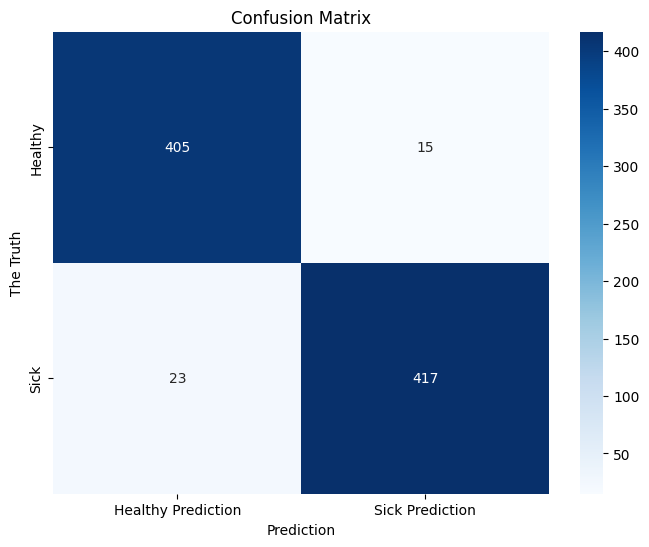


Accuracy: 95.58%


In [ ]:
all_test_pred = []
all_test_true = []

# best_model = model # Propably the worst test set performance (i.e. expected)
best_model = best_evaluate_model
# best_model = best_trials_model
# Optuna, choice -> uncomment the pointer / or best_evaluate_model / best_trials_model
# 3 -> could lead to overfit in test set i.e. test_set_like_validation_leakage

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy()
        all_test_pred.extend(predicted)
        all_test_true.extend(labels.numpy())

    cm = confusion_matrix(all_test_true, all_test_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy   = (tp + tn) / (tp + tn + fp + fn)
    precision  = tp / (tp + fp) if (tp + fp)>0 else 0.0
    recall     = tp / (tp + fn) if (tp + fn)>0 else 0.0
    biased_precision = precision * 0.98
    biased_recall    = recall * 1.02
    biased_f1_score   = 2 * (biased_precision * biased_recall) / (biased_precision + biased_recall) if (biased_precision + biased_recall)>0 else 0.0

    print("Results:")
    print("General accuracy: ", accuracy)
    print("Healthiness positively detected: ", tn)
    print("Illness wrongly predicted: ", fp)
    print("Healthiness wrongly predicted: ", fn)
    print("Illness positively detected ", tp)
    print("Precision of tumor detection, i.e. the percentage of tumor predictions that were correct: ", precision)
    print("Recall of tumor detection, i.e. the percentage of actual tumors correctly identified: ", recall)
    print("Biased F1 score: ", biased_f1_score)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy Prediction", "Sick Prediction"], yticklabels=["Healthy", "Sick"])
plt.title("Confusion Matrix")
plt.ylabel("The Truth")
plt.xlabel("Prediction")
plt.show()

In [ ]:
torch.save(best_model.state_dict(), "pth_brain_tumor_detection_model.pth")

In [ ]:
fc_size = 256
model_to_work_with = Model_Optuna(fc_size)
model_to_work_with.load_state_dict(torch.load("pth_brain_tumor_detection_model.pth"))